In [134]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, plot_confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
%matplotlib inline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error,
        mean_squared_log_error,
        r2_score,
)

In [135]:
df = pd.read_csv("../input/Occupancy_Estimation.csv")

# Cenário 1 - Feature Selection com Wrapper Methods

<AxesSubplot: title={'center': 'Correlação entre features'}>

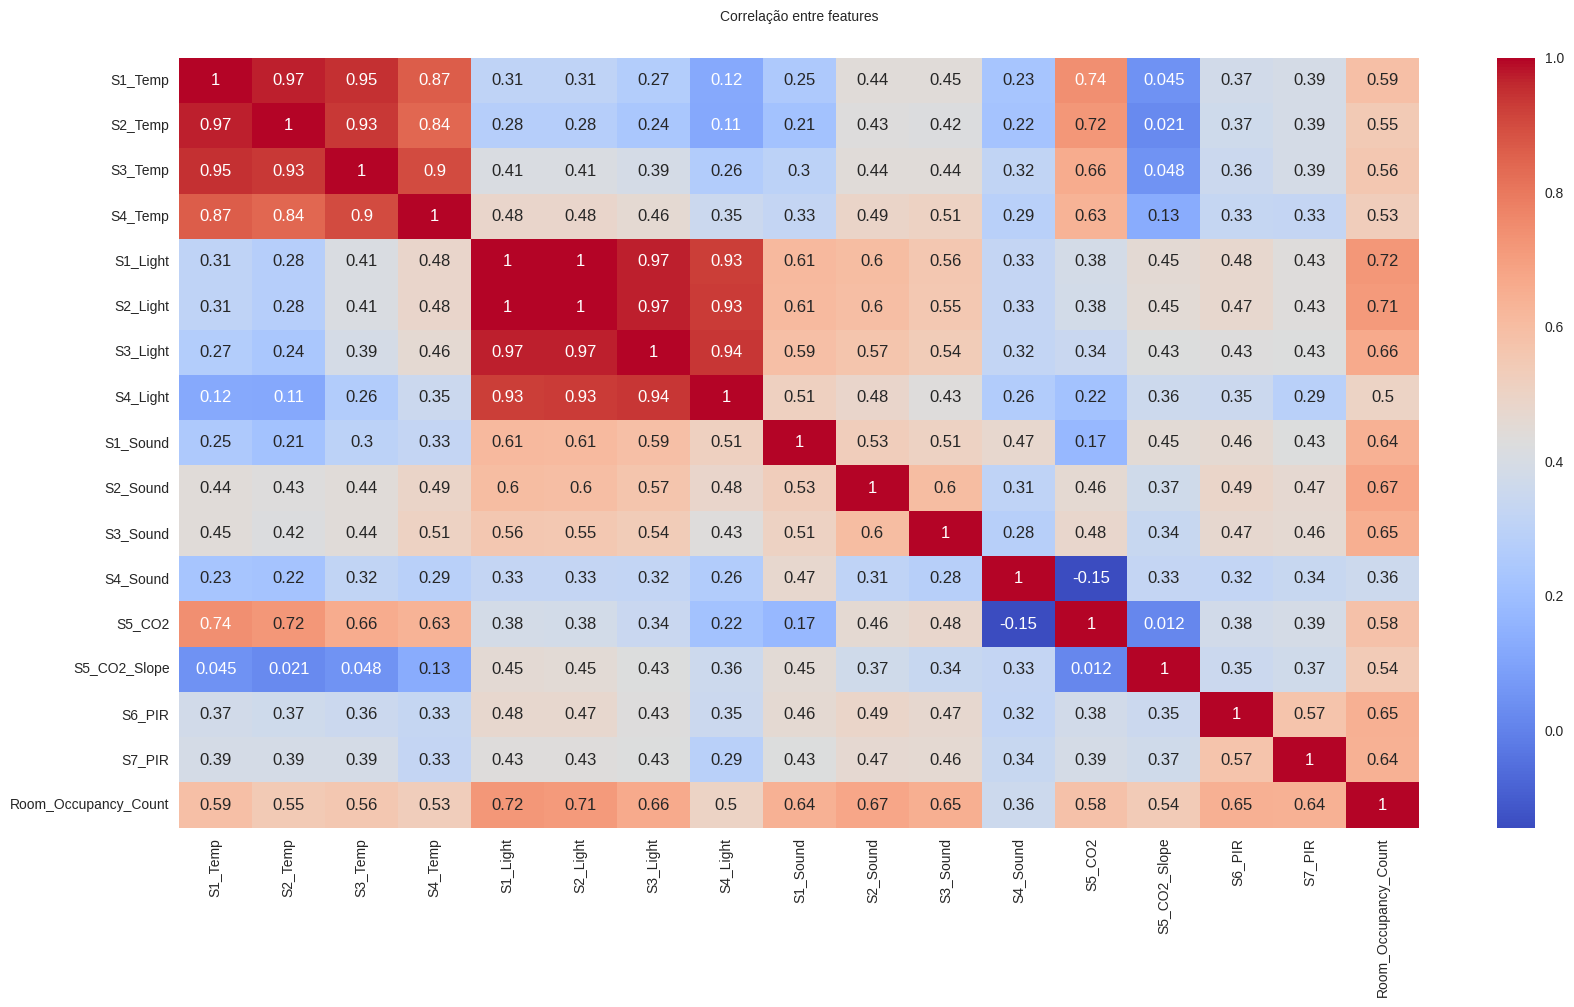

In [136]:
plt.subplots(figsize=(20,10))
plt.title("Correlação entre features", y = 1.03,fontsize = 10, pad = 10)
sns.heatmap(df.corr(method = 'spearman'), annot = True, cmap='coolwarm')

Num sentido de averiguar de modo automático, decidimos testar métodos de *wrapper* para observar quais as *features* que seriam selecionadas.
Vamos tentar:
* *Forward selection*
* *Backward elimination*
* *Bi-directional elimination (Stepwise Selection)*

Como queremos confrontar estas seleções com as que obtivemos no teste de hipóteses, vamos definir o número máximo de features até 6 de modo a incluir uma feature de cada tipo: som, luz, temp, movimento e co2, dando margem de 1 feature

In [137]:
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=(4,5),
          forward=True,
          floating=False,
          cv = 0)

# Sequential Backward Elimination (sbe)
sbe = SFS(LinearRegression(),
         k_features=(4,5),
         forward=False,
         floating=False,
         cv=0)

# Stepwise Selection (ss)
ss = SFS(LinearRegression(),
         k_features=(4,5),
         forward=True,
         floating=True,
         cv=0)

* Transformação das datas

In [138]:
# Só queremos observar a seleção das features das condições ambientais, então, eliminemos as datas.
df2 = df.copy()
df2.drop('Time', axis=1, inplace=True)
df2.drop('Date', axis=1, inplace=True)

In [139]:
#divisão do target
x = df2.drop(['Room_Occupancy_Count'], axis=1)
y = df2['Room_Occupancy_Count']

In [140]:
X_train, x_test, Y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [141]:
print("SFS:\n")
sfs.fit(X_train, Y_train)
print(sfs.k_feature_names_)
print("-"*50)

print("SBE:\n")
sbe.fit(X_train, Y_train)
print(sbe.k_feature_names_)
print("-"*50)

print("SS:\n")
ss.fit(X_train, Y_train)
print(ss.k_feature_names_)
print("-"*50)

SFS:

('S3_Temp', 'S1_Light', 'S5_CO2', 'S5_CO2_Slope', 'S7_PIR')
--------------------------------------------------
SBE:

('S3_Temp', 'S4_Temp', 'S1_Light', 'S5_CO2_Slope', 'S7_PIR')
--------------------------------------------------
SS:

('S3_Temp', 'S1_Light', 'S5_CO2', 'S5_CO2_Slope', 'S7_PIR')
--------------------------------------------------


Então, percebemos que as variáveis mais comuns nos algoritmos são *S3_Temp*, *S1_Light*, *S5_CO2_Slope* e *S7_PIR*, que aparecem 3x. Adiante vamos testar com cada e verificar o que acontece. A nossa seleção não foi esta, então, vamos verificar se obtemos melhores métricas com estas features.

In [142]:
# transformar as datas como fizemos no cenario 0
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])
df['day_of_month'] = df['Date'].dt.day
df['week_day'] = df['Date'].dt.weekday
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
# podemos remover as colunas
df.drop('Time', axis=1, inplace=True)
df.drop('Date', axis=1, inplace=True)

In [143]:
# manter as colunas especificadas acima
# remover colunas correlacionadas
df = df.drop(columns=['S1_Temp', 'S2_Temp', 'S4_Temp', 
                      'S2_Light', 'S3_Light', 'S4_Light', 
                      'S2_Sound', 'S3_Sound', 'S4_Sound',
                      'S5_CO2', 'S6_PIR'
                     ])

## Modelação com estas features

In [144]:
METRICS = {
        "MAE": make_scorer(mean_absolute_error),
        "MSE": make_scorer(mean_squared_error,squared=True),
        "RMSE": make_scorer(mean_squared_error,squared=False),
        "r2_Score": make_scorer(r2_score),
        "RMSLE": make_scorer(mean_squared_log_error,squared=False)
}

X, y = df.drop("Room_Occupancy_Count", axis=1), df["Room_Occupancy_Count"]

## Decision Trees

In [145]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
#Função de kfold com 10 iterações, garante que os resultados são iguais

## DT
dt = DecisionTreeRegressor(max_depth=3, random_state=1234)
scores = cross_validate(dt, X, y, cv=splitter, scoring=METRICS)
dt_scores = pd.DataFrame(scores)
pd.DataFrame(dt_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.009863,0.002966,0.073253,0.057951,0.238802,0.927402,0.108763


In [146]:
# 0.008152	0.002607	0.060198	0.061134	0.245313	0.923407	0.10839

## Random Forest

In [147]:
rf = RandomForestRegressor(max_depth=3, random_state=1234)
scores = cross_validate(rf, X, y, cv=splitter, scoring=METRICS)
rf_scores = pd.DataFrame(scores)
pd.DataFrame(rf_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.468816,0.009551,0.070982,0.052714,0.227873,0.933965,0.104607


In [148]:
# 0.436026	0.009631	0.062394	0.056071	0.235008	0.929755	0.103187

## Extra Trees

In [149]:
et = ExtraTreesRegressor(max_depth=3, random_state=1234)
scores = cross_validate(et, X, y, cv=splitter, scoring=METRICS)
et_scores = pd.DataFrame(scores)
pd.DataFrame(et_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.177921,0.008762,0.088962,0.059161,0.241024,0.925897,0.094383


In [150]:
# 0.189558	0.009823	0.100988	0.087753	0.295433	0.890095	0.127621

## Resultados
A métrica que vamos utilizar, terá em conta a existência de outliers e o desbalanceamento dos dados: RMSLE conjugado com R2_Score.
Vamos, neste caso, utilizar o RMSLE tendo em conta a distribuição anormal dos dados, e que, como não está corrigida, terá maior peso.

* DT: pior RMSLE, melhor R2 -> pior
* RF: pior RMSLE, melhor R2 -> pior
* ET: melhor RMSLE, pior R2 -> melhor

Assim sendo, verificamos que a melhor aboragem continua a ser a do cenário 0.

Seguir para o notebook 2.